In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm

In [2]:
load_dotenv()
folder_path = os.getenv('path_vrubel_pics')

In [3]:
def preprocess_image(filename, type_of_analysis):
    filepath = os.path.join(folder_path, filename)
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512)) 
    if type_of_analysis == 'lines':
        edges = cv2.Canny(image, 100, 200)
        year = filename.split('_')[0]
        return image, edges, year
    elif type_of_analysis == 'circles':
        year = filename.split('_')[0]
        return image, year 

In [4]:
# def analyse_lines(folder_path, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=10):
#     results = {}
#     line_length_for_paintings = {}
#     line_length_for_years = {}
#     straight_lines_count_for_paintings = {}
#     straight_lines_count_for_years = {}
#     straight_lines_length_for_years = {}
    
#     for filename in tqdm(os.listdir(folder_path)):
#         if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
#             image, edges, year = preprocess_image(filename, type_of_analysis='lines')
#             if year != "yyyy":
                
#                 # gets lengths of lines for each painting
#                 edge_length = np.sum(edges > 0)
#                 height, width = image.shape
#                 area = height * width
#                 normalized_length = edge_length / area
                
#                 line_length_for_paintings[filename] = normalized_length

#                 # gets lengths of lines for each year
#                 if year in line_length_for_years:
#                     line_length_for_years[year].append(normalized_length)
#                 else:
#                     line_length_for_years[year] = [normalized_length]
                    
#                 # gets straight lines for each painting
#                 lines = cv2.HoughLinesP(edges, 
#                                         rho, # шаг в пикселях по оси x
#                                         theta, # шаг в радианах по углу
#                                         threshold, # минимальное количество точек на линии
#                                         minLineLength, # минимальная длина линии
#                                         maxLineGap) # максимальный разрыв между частями линии
#                 num_lines = len(lines) if lines is not None else 0
#                 height, width = image.shape
#                 area = height * width
#                 normalized_lines = num_lines / area
#                 straight_lines_count_for_paintings[filename] = normalized_lines
                
#                 # gets straight lines for each year
#                 if year in straight_lines_count_for_years:
#                     straight_lines_count_for_years[year].append(normalized_lines)
#                 else:
#                     straight_lines_count_for_years[year] = [normalized_lines]
                    
#                 # Calculate the average line length for each painting
#                 total_line_length = 0
#                 if lines is not None:
#                     for line in lines:
#                         x1, y1, x2, y2 = line[0]
#                         length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) # length of a line
#                         total_line_length += length

#                 if year in straight_lines_length_for_years:
#                     straight_lines_length_for_years[year].append(total_line_length)
#                 else:
#                     straight_lines_length_for_years[year] = [total_line_length]
    
#     averaged_results_year = {year: np.mean(values) for year, values in line_length_for_years.items()}
#     sorted_results_year = dict(sorted(averaged_results_year.items(), key=lambda x: int(x[0])))
    
#     averaged_results_str_year = {year: np.mean(values) for year, values in straight_lines_count_for_years.items()}
#     sorted_results_str_year = dict(sorted(averaged_results_str_year.items(), key=lambda x: int(x[0])))
    
#     averaged_results_line_length = {year: np.mean(values) for year, values in straight_lines_length_for_years.items()}
#     sorted_results_line_length = dict(sorted(averaged_results_line_length.items(), key=lambda x: int(x[0])))

#     results['line_length_for_paintings'] = line_length_for_paintings
#     results['line_length_for_year'] = sorted_results_year
#     results['straight_lines_count_for_paintings'] = straight_lines_count_for_paintings
#     results['straight_lines_count_for_year'] = sorted_results_str_year 
#     results['straight_lines_length_for_years'] = sorted_results_line_length
    
#     return results

In [5]:
def analyse_lines(folder_path, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=10):
    results = {}
    line_length_for_paintings = {}
    line_length_for_years = {}
    straight_lines_count_for_paintings = {}
    straight_lines_count_for_years = {}
    straight_lines_length_for_years = {}
    all_lines_count_for_years = {}

    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
            image, edges, year = preprocess_image(filename, type_of_analysis='lines')
            if year != "yyyy":
                height, width = image.shape
                area = height * width

                # Edge length
                edge_length = np.sum(edges > 0)
                normalized_length = edge_length / area
                line_length_for_paintings[filename] = normalized_length
                line_length_for_years.setdefault(year, []).append(normalized_length)

                # Straight lines
                lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength, maxLineGap)
                num_lines = len(lines) if lines is not None else 0
                normalized_lines = num_lines / area
                straight_lines_count_for_paintings[filename] = normalized_lines
                straight_lines_count_for_years.setdefault(year, []).append(normalized_lines)

                # Total straight line length
                total_line_length = 0
                if lines is not None:
                    for line in lines:
                        x1, y1, x2, y2 = line[0]
                        total_line_length += np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                straight_lines_length_for_years.setdefault(year, []).append(total_line_length)

                # All lines (contours)
                contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                num_all_lines = len(contours)
                normalized_all_lines = num_all_lines / area
                all_lines_count_for_years.setdefault(year, []).append(normalized_all_lines)

    # Averages and sorted results
    averaged_results_year = {y: np.mean(v) for y, v in line_length_for_years.items()}
    sorted_results_year = dict(sorted(averaged_results_year.items(), key=lambda x: int(x[0])))

    averaged_results_str_year = {y: np.mean(v) for y, v in straight_lines_count_for_years.items()}
    sorted_results_str_year = dict(sorted(averaged_results_str_year.items(), key=lambda x: int(x[0])))

    averaged_results_line_length = {y: np.mean(v) for y, v in straight_lines_length_for_years.items()}
    sorted_results_line_length = dict(sorted(averaged_results_line_length.items(), key=lambda x: int(x[0])))

    averaged_all_lines_count = {y: np.mean(v) for y, v in all_lines_count_for_years.items()}
    sorted_all_lines_count = dict(sorted(averaged_all_lines_count.items(), key=lambda x: int(x[0])))

    # Results
    results['line_length_for_paintings'] = line_length_for_paintings
    results['line_length_for_year'] = sorted_results_year
    results['straight_lines_count_for_paintings'] = straight_lines_count_for_paintings
    results['straight_lines_count_for_year'] = sorted_results_str_year 
    results['straight_lines_length_for_years'] = sorted_results_line_length
    results['all_lines_count_for_year'] = sorted_all_lines_count

    return results

In [6]:
results_lines = analyse_lines(folder_path)

  0%|          | 0/136 [00:00<?, ?it/s]

100%|██████████| 136/136 [00:04<00:00, 29.83it/s]


In [7]:
def analyse_circles(folder_path, dp=1.2, minDist=20, param1=50, param2=30, minRadius=10, maxRadius=100):
    results = {}
    circle_count_for_paintings = {}
    circle_count_for_years = {}
    mean_radius_for_years = {}
    
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
            image, year = preprocess_image(filename, type_of_analysis='circles')
            h, w = image.shape[:2]  
            image_area = h * w 
            
            if year != "yyyy":
                
                # gets count of circles for each painting
                blurred = cv2.GaussianBlur(image, (9, 91), 2)
                circles = cv2.HoughCircles(
                    blurred, 
                    cv2.HOUGH_GRADIENT, 
                    dp, 
                    minDist, 
                    param1, 
                    param2, 
                    minRadius, 
                    maxRadius
                )

                num_circles = 0 if circles is None else len(circles[0])
                
                # gets count of circles for each year
                if year not in circle_count_for_years:
                    circle_count_for_years[year] = 0
                circle_count_for_years[year] += num_circles
                
                circle_count_for_paintings[filename] = num_circles
                
                # gets average radius of circles for year
                
                if year not in mean_radius_for_years:
                    mean_radius_for_years[year] = {"num_circles": 0, "radius_sum": 0, "normalized_radius_sum": 0, "radii": [], "normalized_radii": []}
                    
                if circles is not None:
                    circles = np.round(circles[0, :]).astype("int")

                    for (x, y, r) in circles:
                        normalized_radius = r / np.sqrt(image_area) 

                        mean_radius_for_years[year]["num_circles"] += 1
                        mean_radius_for_years[year]["radius_sum"] += r
                        mean_radius_for_years[year]["normalized_radius_sum"] += normalized_radius
                        mean_radius_for_years[year]["radii"].append(r)
                        mean_radius_for_years[year]["normalized_radii"].append(normalized_radius)
                else:
                    mean_radius_for_years[year]["num_circles"] = 0 
                    mean_radius_for_years[year]["radius_sum"] = 0
                    mean_radius_for_years[year]["normalized_radius_sum"] = 0
                    mean_radius_for_years[year]["radii"] = []
                    mean_radius_for_years[year]["normalized_radii"] = []
    
    for year in mean_radius_for_years:
        if mean_radius_for_years[year]["num_circles"] > 0:
            num_circles = mean_radius_for_years[year]["num_circles"]
            
            # mean radii
            avg_radius = mean_radius_for_years[year]["radius_sum"] / num_circles
            avg_normalized_radius = mean_radius_for_years[year]["normalized_radius_sum"] / num_circles
            
            # std
            radii = np.array(mean_radius_for_years[year]["radii"])
            normalized_radii = np.array(mean_radius_for_years[year]["normalized_radii"])

            std_radius = np.std(radii)  
            std_normalized_radius = np.std(normalized_radii) 

            mean_radius_for_years[year]["average_radius"] = avg_radius
            mean_radius_for_years[year]["average_normalized_radius"] = avg_normalized_radius
            mean_radius_for_years[year]["std_radius"] = std_radius
            mean_radius_for_years[year]["std_normalized_radius"] = std_normalized_radius
        else:
            mean_radius_for_years[year]["average_radius"] = 0
            mean_radius_for_years[year]["average_normalized_radius"] = 0
            mean_radius_for_years[year]["std_radius"] = 0
            mean_radius_for_years[year]["std_normalized_radius"] = 0
        
    results['circle_count_for_paintings'] = circle_count_for_paintings
    results['circle_count_for_years'] = circle_count_for_years
    results['mean_radius_for_years'] = mean_radius_for_years

    return results

In [8]:
results_circles = analyse_circles(folder_path)

100%|██████████| 136/136 [00:58<00:00,  2.32it/s]


#### Смотрим количество границ на каждой картине

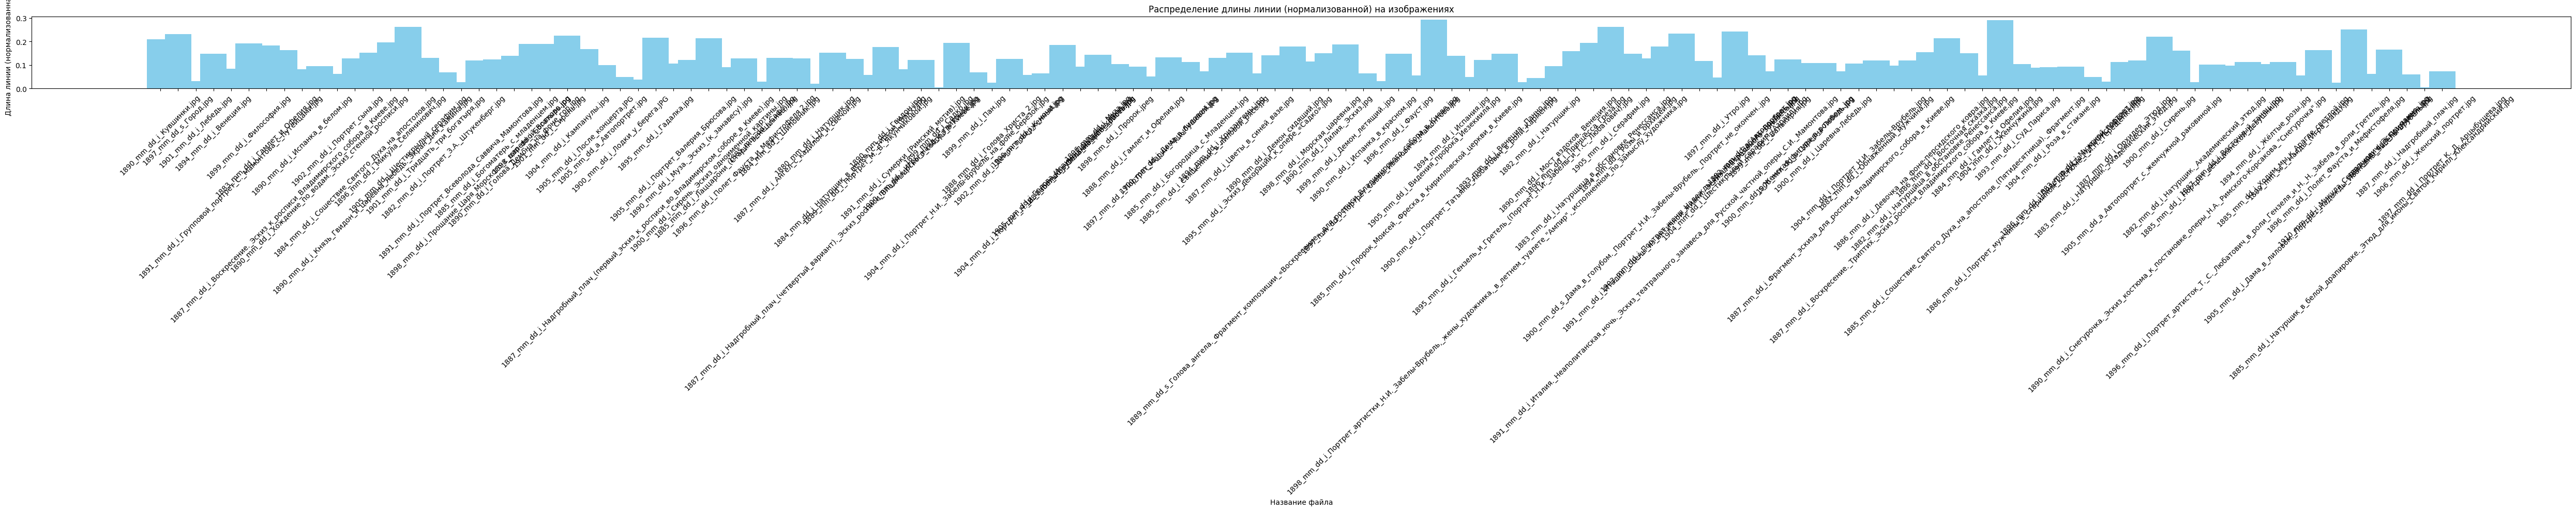

In [9]:
filenames = list(results_lines['line_length_for_paintings'].keys())
values = list(results_lines['line_length_for_paintings'].values())
bar_width = 1.5
plt.figure(figsize=(50, 10))
plt.bar(filenames, values, color='skyblue', width=bar_width)
plt.xlabel('Название файла')
plt.ylabel('Длина линии (нормализованная)')
plt.title('Распределение длины линии (нормализованной) на изображениях')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество границ на картинах за год

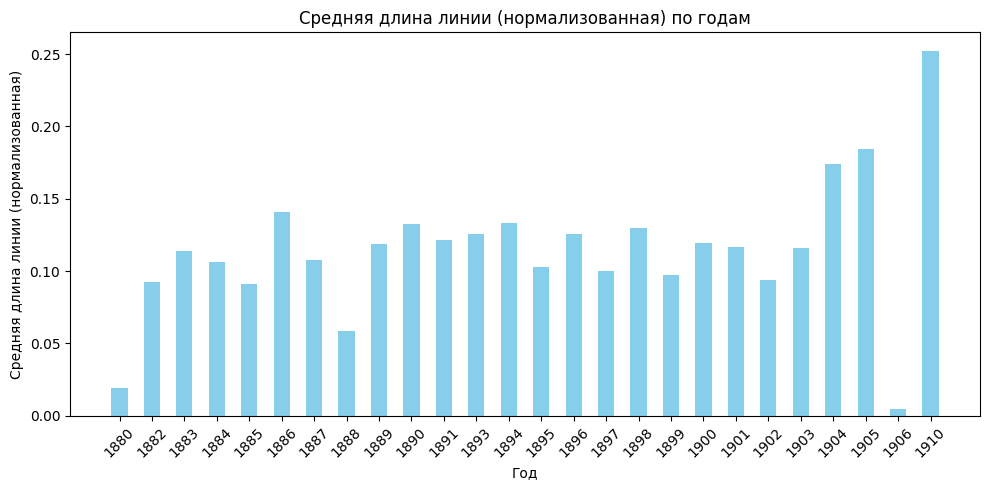

In [10]:
years = list(results_lines['line_length_for_year'].keys())
values = list(results_lines['line_length_for_year'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Средняя длина линии (нормализованная)')
plt.title('Средняя длина линии (нормализованная) по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

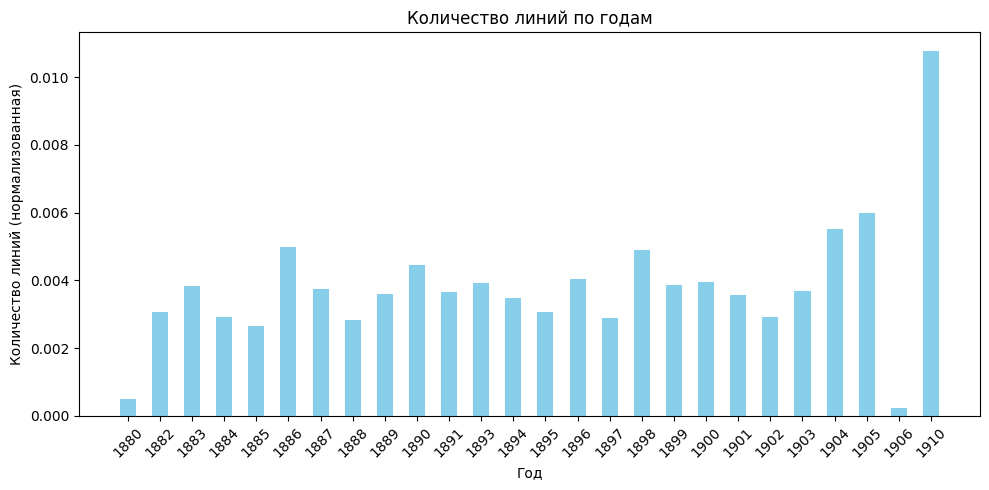

In [11]:
# all_lines_count_for_year

years = list(results_lines['all_lines_count_for_year'].keys())
values = list(results_lines['all_lines_count_for_year'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Количество линий (нормализованная)')
plt.title('Количество линий по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество прямых линий на каждой картине

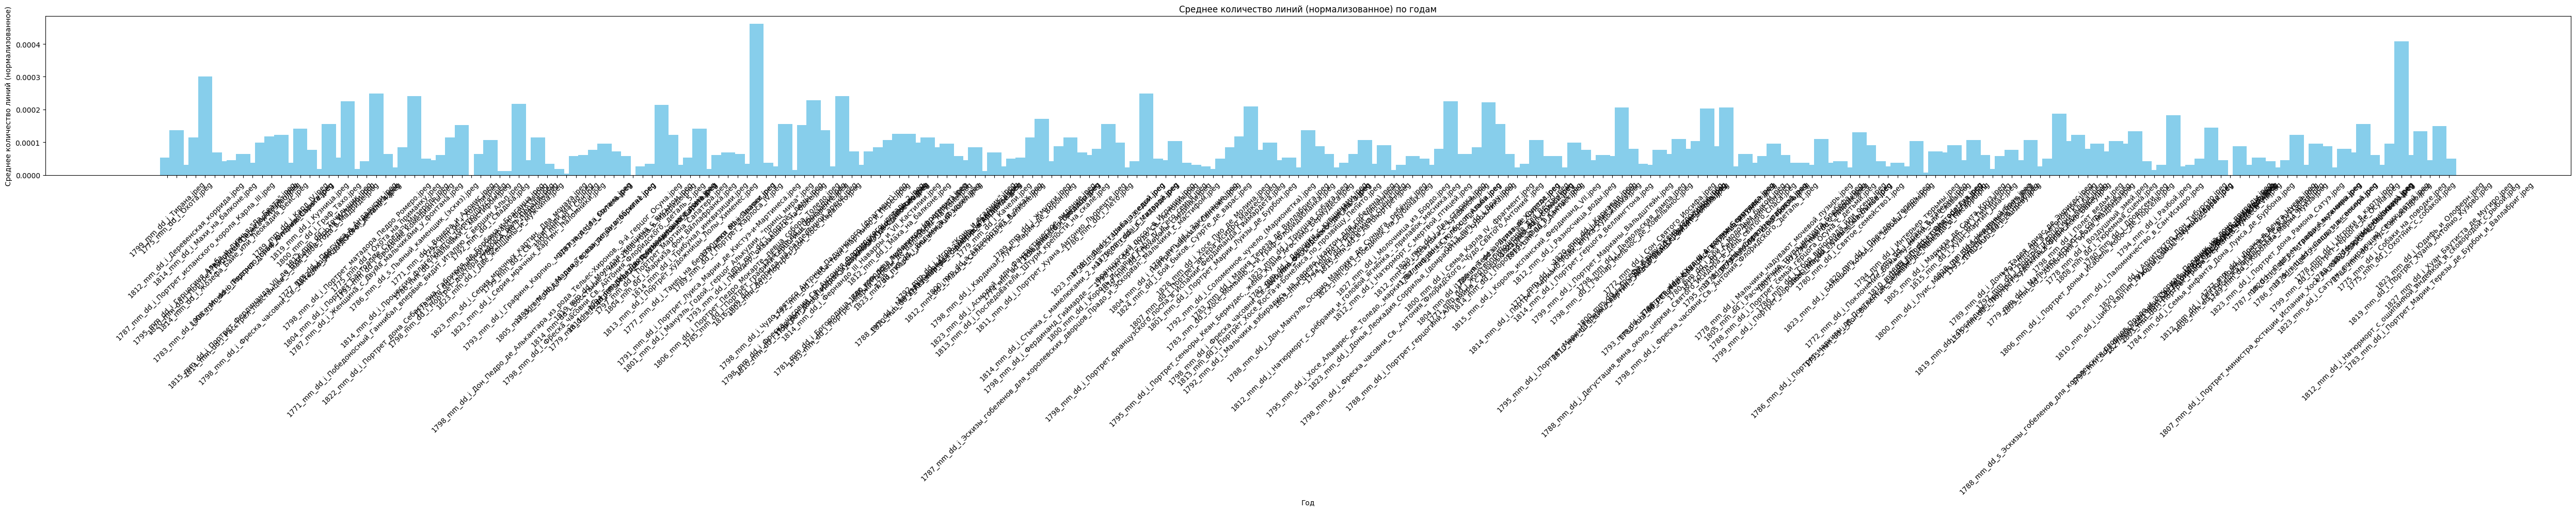

In [12]:
years = list(results_lines['straight_lines_count_for_paintings'].keys())
values = list(results_lines['straight_lines_count_for_paintings'].values())
bar_width = 1.5
plt.figure(figsize=(50, 10))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Среднее количество линий (нормализованное)')
plt.title('Среднее количество линий (нормализованное) по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество прямых линий по годам

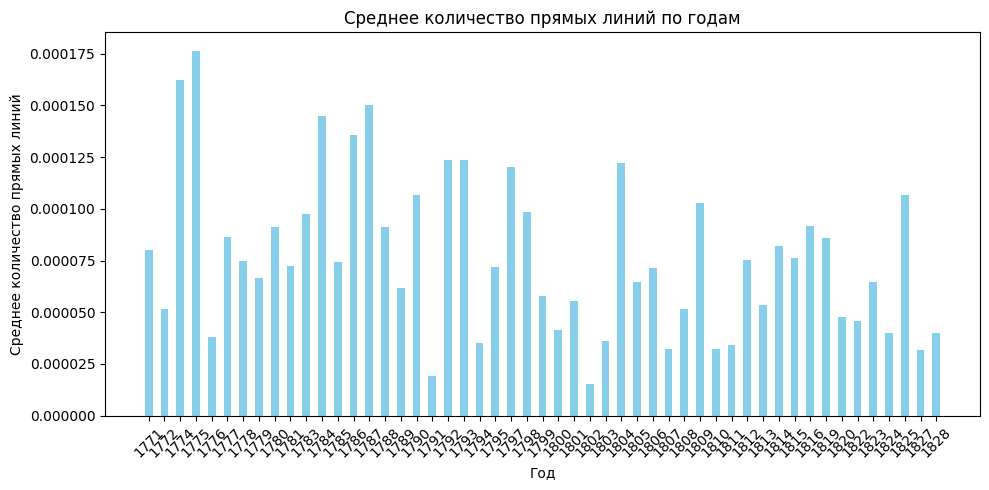

In [13]:
years = list(results_lines['straight_lines_count_for_year'].keys())
values = list(results_lines['straight_lines_count_for_year'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Среднее количество прямых линий')
plt.title('Среднее количество прямых линий по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим среднюю длину прямых линий за год

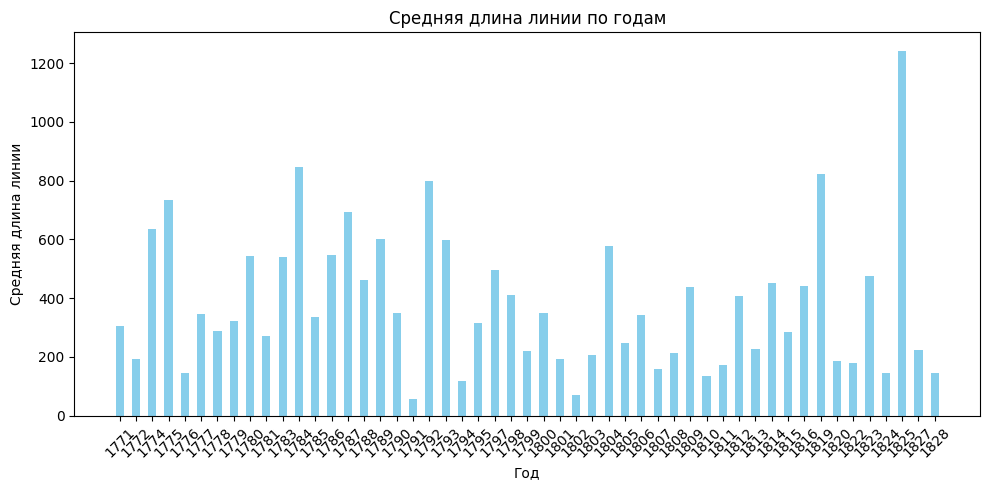

In [14]:
years = list(results_lines['straight_lines_length_for_years'].keys())
values = list(results_lines['straight_lines_length_for_years'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Средняя длина линии')
plt.title('Средняя длина линии по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество кружков на каждой картине

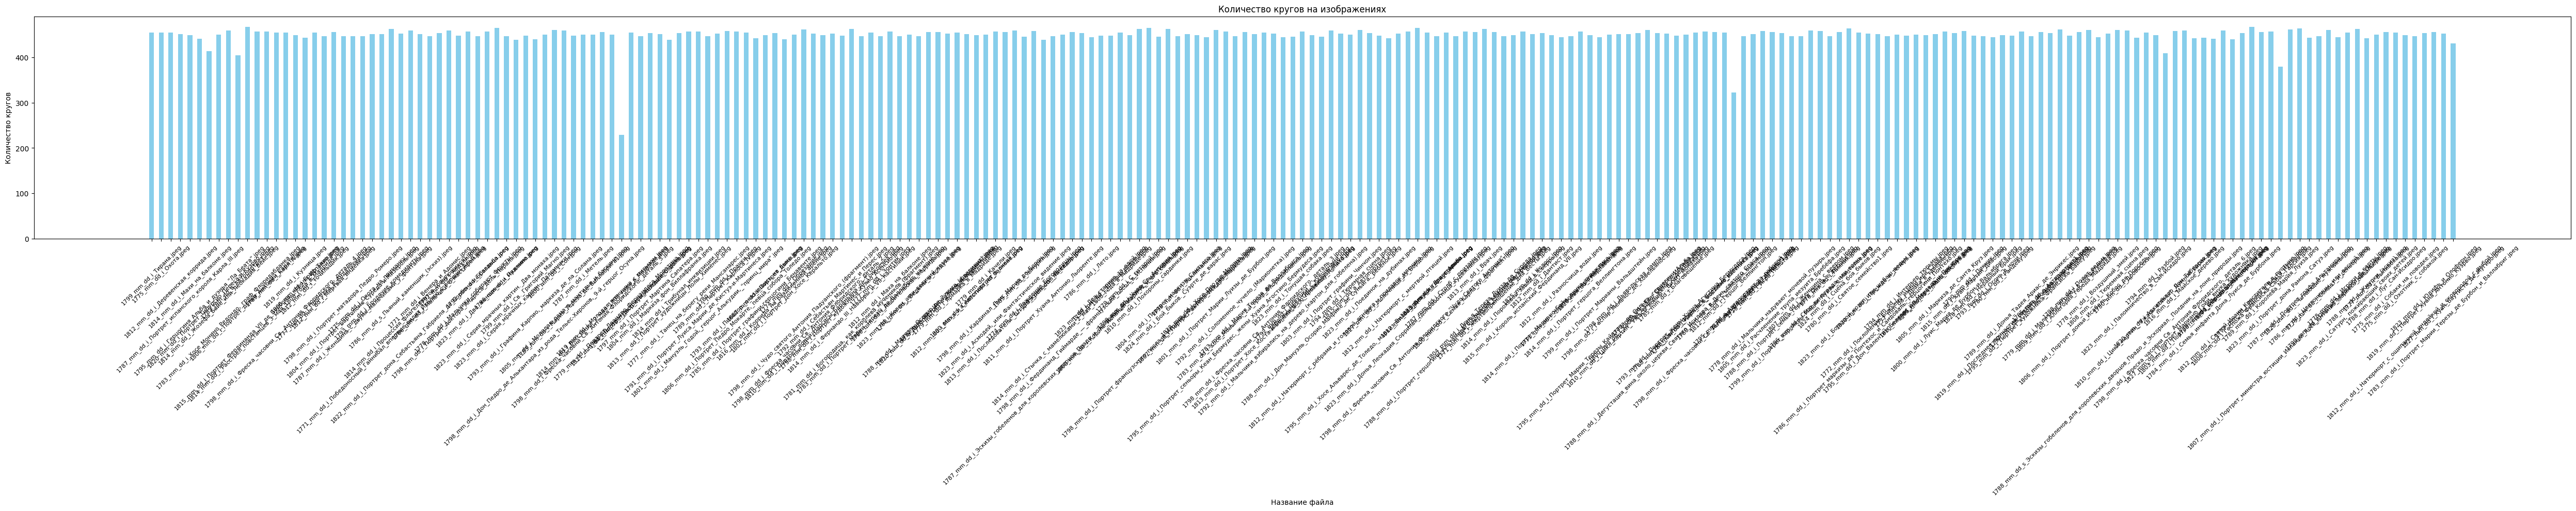

In [15]:
filenames = list(results_circles['circle_count_for_paintings'].keys())
values = list(results_circles['circle_count_for_paintings'].values())
bar_width = 0.5
plt.figure(figsize=(50, 10))
plt.bar(filenames, values, color='skyblue', width=bar_width)
plt.xlabel('Название файла')
plt.ylabel('Количество кругов')
plt.title('Количество кругов на изображениях')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

#### Смотрим количество кружков за каждый год

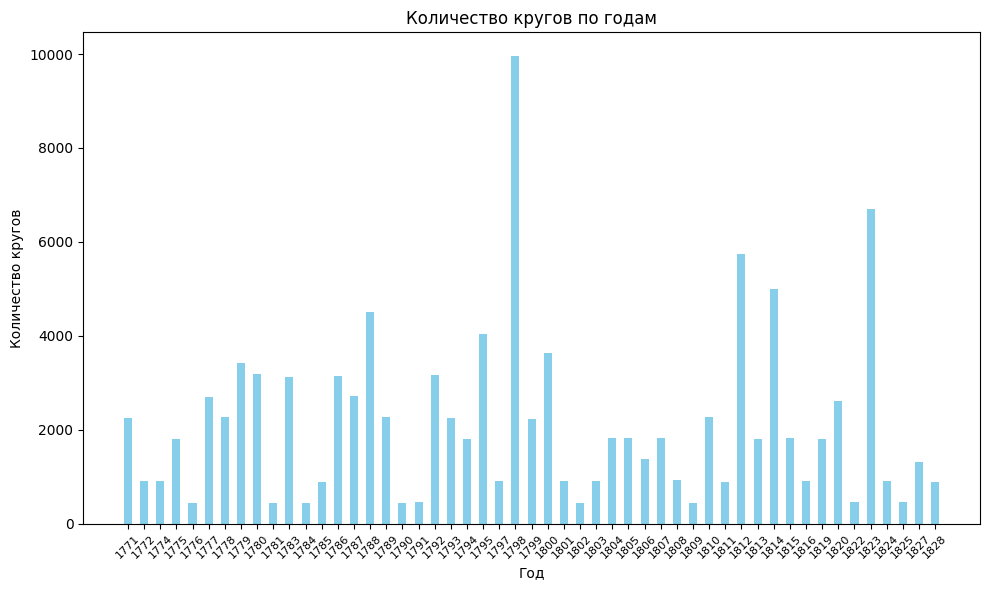

In [16]:
sorted_results = dict(sorted(results_circles['circle_count_for_years'].items()))

years = list(sorted_results.keys())
values = list(sorted_results.values())
bar_width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Количество кругов')
plt.title('Количество кругов по годам')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

## Смотрим средний радиус кружков

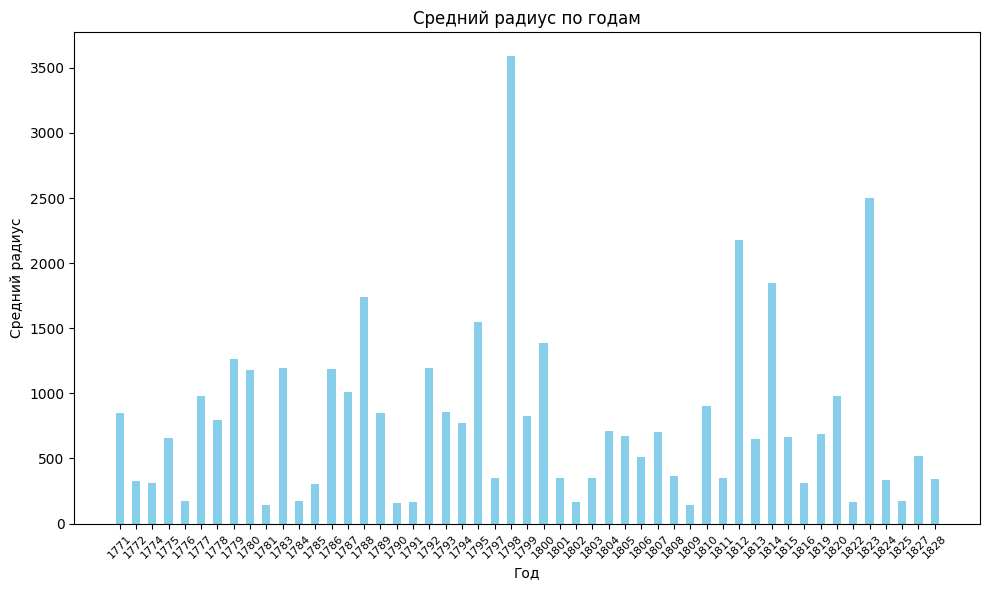

In [17]:
results_count_normalized_radius_sum = {year: data['normalized_radius_sum'] for year, data in results_circles['mean_radius_for_years'].items()}

sorted_results_results_count_normalized_radius_sum = dict(sorted(results_count_normalized_radius_sum.items()))
years_results_count_normalized_radius_sum = list(sorted_results_results_count_normalized_radius_sum.keys())
values_results_count_normalized_radius_sum = list(sorted_results_results_count_normalized_radius_sum.values())
bar_width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(years_results_count_normalized_radius_sum, values_results_count_normalized_radius_sum, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Средний радиус')
plt.title('Средний радиус по годам')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

## Смотрим среднеквадратичное отклонение

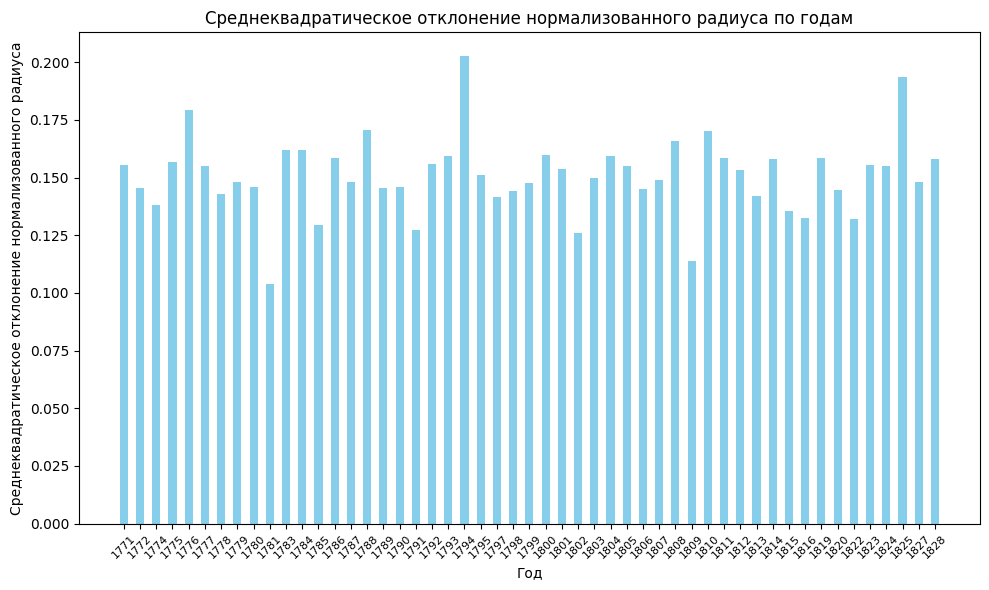

In [18]:
results_count_std_normalized_radius = {year: data["std_normalized_radius"] for year, data in results_circles['mean_radius_for_years'].items()}

sorted_results_std_normalized_radius = dict(sorted(results_count_std_normalized_radius.items())) 
years_std_normalized_radius = list(sorted_results_std_normalized_radius.keys()) 
values_std_normalized_radius = list(sorted_results_std_normalized_radius.values())

bar_width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(years_std_normalized_radius, values_std_normalized_radius, color='skyblue', width=bar_width)
    
plt.xlabel('Год')
plt.ylabel('Среднеквадратическое отклонение нормализованного радиуса')
plt.title('Среднеквадратическое отклонение нормализованного радиуса по годам')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

## Собираем в датасет

In [19]:
import pandas as pd

In [20]:
for i in results_lines:
    print(i)

line_length_for_paintings
line_length_for_year
straight_lines_count_for_paintings
straight_lines_count_for_year
straight_lines_length_for_years
all_lines_count_for_year


In [21]:
line_length_for_year = pd.DataFrame(list(results_lines['line_length_for_year'].items()), columns=['year', 'line_length'])
len(line_length_for_year)

51

In [22]:
straight_lines_count_for_year = pd.DataFrame(list(results_lines['straight_lines_count_for_year'].items()), columns=['year', 'straight_lines_count'])
len(straight_lines_count_for_year)

51

In [23]:
straight_lines_length_for_years = pd.DataFrame(list(results_lines['straight_lines_length_for_years'].items()), columns=['year', 'straight_lines_length'])
len(straight_lines_length_for_years)

51

In [24]:
for i in results_circles:
    print(i)

circle_count_for_paintings
circle_count_for_years
mean_radius_for_years


In [25]:
circle_count_for_years = pd.DataFrame(list(results_circles['circle_count_for_years'].items()), columns=['year', 'circle_count'])
len(circle_count_for_years)

51

In [26]:
normalized_radius_sum = pd.DataFrame({
    "year": years_results_count_normalized_radius_sum,
    "normalized_radius_sum": values_results_count_normalized_radius_sum
})

len(normalized_radius_sum)

51

In [27]:
std_normalized_radius = pd.DataFrame({
    "year": years_std_normalized_radius,
    "normalized_radius_sum": values_std_normalized_radius
})

len(std_normalized_radius)

51

In [28]:
df_merged = line_length_for_year.merge(straight_lines_count_for_year, on="year", how="outer").merge(straight_lines_length_for_years, on="year", how="outer")
df_merged = df_merged.merge(circle_count_for_years, on="year", how="outer") #.merge(normalized_radius_sum, on="year", how="outer")
df_merged = df_merged.merge(std_normalized_radius, on="year", how="outer")

df_merged = df_merged.sort_values("year").reset_index(drop=True)

df_merged.head()

year  line_length  straight_lines_count  straight_lines_length  \
0  1771     0.045379              0.000080             306.139562   
1  1772     0.049492              0.000051             193.974165   
2  1774     0.059576              0.000162             633.826326   
3  1775     0.074185              0.000176             734.081307   
4  1776     0.059196              0.000038             144.480789   

   circle_count  normalized_radius_sum  
0          2252               0.155511  
1           899               0.145700  
2           908               0.138167  
3          1808               0.156966  
4           447               0.179312

In [29]:
len(df_merged)

51

In [30]:
df_merged.to_csv('dataset_lines_circles.csv', index=False)

## Рисуем линии

In [ ]:
def draw_lines_on_image(image_path, save_path=True, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=10, show=True):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Не удалось открыть изображение: {image_path}")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)

    image_with_lines = image.copy()

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2) 

    if save_path:
        cv2.imwrite(save_path, image_with_lines)

    if show:
        image_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title('Изображение с прямыми линиями')
        plt.show()

    return image_with_lines

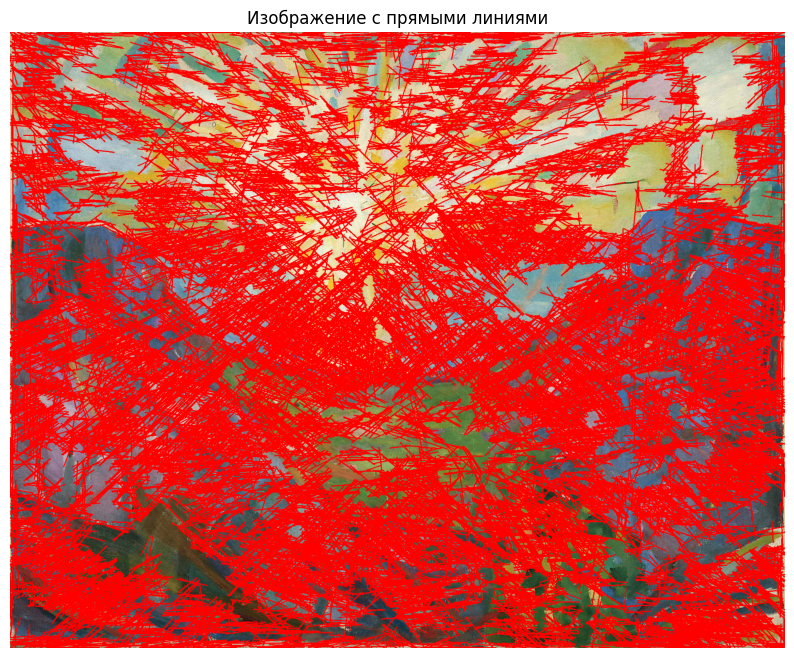

array([[[  0,   0, 255],
        [  0,   0, 255],
        [171, 201, 228],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [154, 183, 204],
        [117, 146, 167]],

       ...,

       [[ 62,  91, 118],
        [ 75, 105, 132],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [ 94, 125, 146]],

       [[ 56,  91, 117],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [ 84, 115, 138]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [ 98, 129, 152]]

In [ ]:
draw_lines_on_image(
    image_path="/Users/alinamaksimova/Desktop/работа/shadows of mind/dataset/Edvard Munch/paintings/1913_mm_dd_i_Солнце.jpg",
    save_path="/Users/alinamaksimova/Desktop/Солнце.jpg",
    show=True 
)

In [ ]:
def draw_all_lines_on_image(image_path, save_path=None, show=True):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Не удалось открыть изображение: {image_path}")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    edges = cv2.Canny(gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 1) 

    if save_path:
        cv2.imwrite(save_path, image_with_contours)

    if show:
        image_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    return image_with_contours

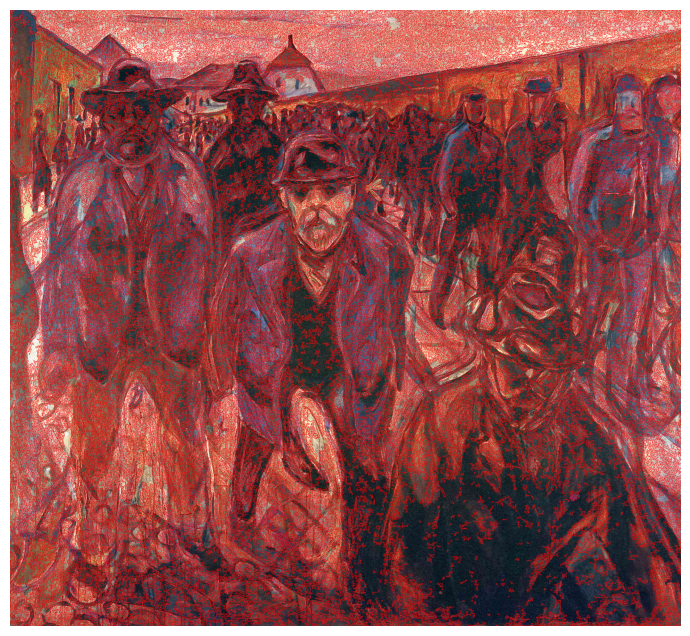

array([[[  0,   0, 255],
        [  0,   0, 255],
        [144, 136, 146],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [134, 156, 174]],

       [[ 44,  36,  46],
        [  0,   0, 255],
        [129, 121, 131],
        ...,
        [177, 199, 217],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[ 49,  43,  48],
        [  0,   0, 255],
        [124, 118, 123],
        ...,
        [179, 201, 219],
        [  0,   0, 255],
        [164, 186, 204]],

       ...,

       [[ 71,  82, 109],
        [ 73,  84, 111],
        [ 79,  90, 117],
        ...,
        [ 56,  52,  81],
        [ 54,  50,  79],
        [ 55,  51,  80]],

       [[ 73,  84, 111],
        [ 74,  85, 112],
        [ 80,  91, 118],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[ 83,  94, 121],
        [ 84,  95, 122],
        [ 88,  99, 126],
        ...,
        [101, 102, 116],
        [105, 106, 120],
        [101, 102, 116]]

In [27]:
draw_all_lines_on_image(
    image_path="/Users/alinamaksimova/Desktop/работа/shadows of mind/dataset/Edvard Munch/paintings/1915_mm_dd_i_Рабочие_на_пути_домой.jpg",
    save_path="/Users/alinamaksimova/Desktop/Рабочие на пути домой.jpg",  # опционально
    show=True
)

In [31]:
def draw_circles_on_image(image_path, output_path, dp=1.2, minDist=20, param1=50, param2=30, minRadius=10, maxRadius=100):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")

    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (9, 91), 2)

    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp, 
        minDist, 
        param1=param1, 
        param2=param2, 
        minRadius=minRadius, 
        maxRadius=maxRadius
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 1)  
            cv2.circle(output, (x, y), 2, (0, 0, 255), 2)   

    cv2.imwrite(output_path, output)
    print(f"Изображение с кругами сохранено в: {output_path}")

In [32]:
draw_circles_on_image(
    image_path="/Users/alinamaksimova/Desktop/работа/shadows of mind/dataset/Francisco Goya/paintings/1788_mm_dd_i_Святой_Франциск_Борджиа_изгоняет.jpeg",
    output_path="/Users/alinamaksimova/Desktop/1788_mm_dd_i_Святой_Франциск_Борджиа_изгоняет.jpeg",  # опционально
)

Изображение с кругами сохранено в: /Users/alinamaksimova/Desktop/1788_mm_dd_i_Святой_Франциск_Борджиа_изгоняет.jpeg
